# Логика разбиения

1. Конечная цель состоит в том, чтобы создать тренировочные и тестовые датасеты для рекомендательной системы, используя предоставленные(от организаторов) данные train_main.parquet и test_main.parquet.
- **test_main.parquet** я оставляю для оценки лучшего решения на kaggle leaderbord (LB)

2. Кроме LB я буду оценивать свои решения локально, поэтому мне нужно создать из **train_main** трен. и тест. части  
Разделю **train_main.parquet** (4 недели данных) на 3 первые недели - **tr_3_first_w**, и последнюю неделю - **tr_last_w**.
- **tr_3_first_w** - первые 3 недели - пойдут на создание трен. датасета кандидатов и их обучение
- **tr_last_w** - последняя 1 неделя - пойдет на локальную валидацию (создание тест. датасета кандидатов и оценка на них) \
Придерживаюсь логики организаторов - в **tr_last_w** будут только сессии, которых нет в **tr_3_first_w**, чтобы сохранить полные истории сессий. Это необходимо, чтобы обеспечить непрерывность данных и учесть, что сессии, начатые ранее, могут быть неполными в текущей части данных.

3. Общая логика создания кандидатов для рекомендаций:
- Как в тренировочной, так и в тестовой части - я разделяю каждую сессию пополам (хронологически)
- Первая половина содержит первую половину истории сессий, на основе которой я создаю рекомендации,  
которые должны предсказать поведение пользователей во второй половине сессий
- Выходит, что первая половина - это основа для создания тренировочного датасета, а вторая  
это таргеты (в случае трен.датасета) или тестовые метки (в случае тест.датасета)

4. Таким образом из **tr_last_w** я получаю **test_candidates_sessions** и **test_labels_loc** -  
первую и вторую половины
- **test_candidates_sessions** - для построения тестового датасета кандидатов
- **test_labels_loc** - тестовые метки для оценки нашей рек.системы

5. Но в случае с **tr_3_first_w** будет чуть по-другому
- Я **не возьму** первую половину каждой сессии **tr_3_first_w** в качестве базы для обучения, т.к это \
слишком большая вычислительная нагрузка. Я возьму меньше данных, но из-за изнач.обьема и этого  
будет достаточно для обучения.   
Я **возьму** только последнюю неделю от **tr_3_first_w** - это будет **train_third_w** - и уже ее поделю на  
две половины (по сессиям):
- **tr_candidates_sessions** - для построения тренировочного датасета кандидатов
- **targets** - таргеты для обучения ранжирующих моделей \
Остаются первые 2 недели от **tr_3_first_w** - это будет **tr_2_first_w** - и ее я использую для создания  
матрицы со-посещений (covis matrix) и для генерации признаков нашего трен.датасета

**Итого**  
1. Создаю тренировочный датасет кандидатов для ранжирования:
- из истории сессий, матрицы со-посещений, популярных aid - создаю самих кандидатов
- из tr_candidates_sessions, tr_2_first_w - создаю session, item, session-item признаки
- из targets добавляю таргеты  
Обучаю модели на этих датасетах (для модели предсказания каждого типа - я строю свой такой датасет)
<br>
2. Создаю тестовый датасет кандидатов для ранжирования:
- из истории сессий, матрицы со-посещений, популярных aid - создаю самих кандидатов
- из test_candidates_sessions, tr_3_first_w - создаю session, item, session-item признаки  
Получаю предсказания на тестовом датасете (для  модели предсказания каждого типа - свое  
предсказание на своем таком датасете)
<br>
3. Собираю 3 датасета предсказаний (clicks,carts,orders) вместе
4. Провожу локальную оценку на test_labels_loc
5. Обучаю лучшее решение на всем train_main - предсказания на test_maing - получаю оценку на LB

**Как я получаю и использую матрицы со-посещений covis_matrix - я расскажу в ноутбуке  
про создание кандидатов**

6. На этом изображении я отразил все визуально + показал на чем строятся признаки,  
матрицы ко-посещений, топы популярности + на чем я в итоге обучаюсь и тестирую

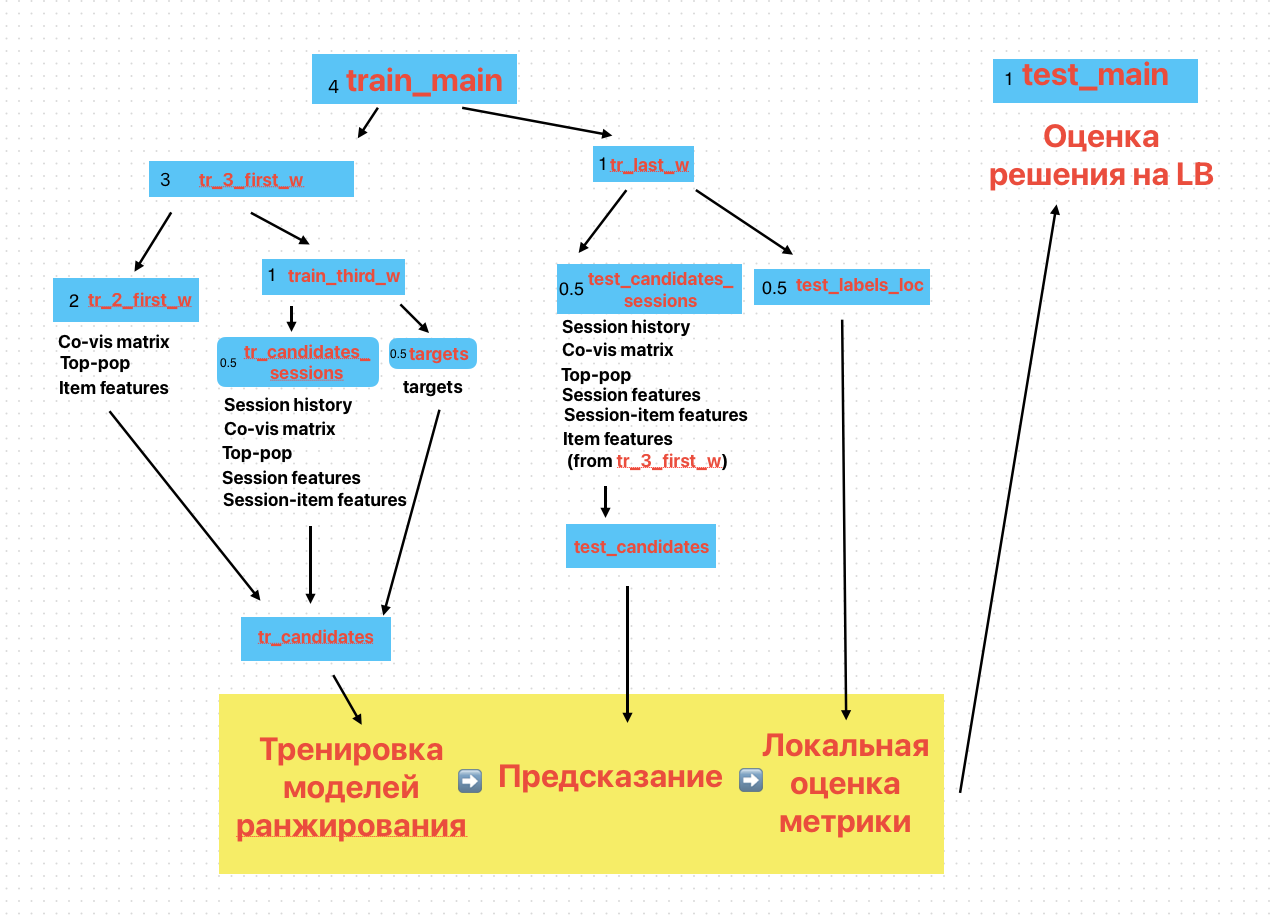

In [3]:
from IPython import display

display.Image(f"{main_path}/images/split_1.png")

# IMPORT

In [2]:
main_path = '/Users/stanislavkrupnov/Jup.Notebook'

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
from pathlib import Path
import random
from tqdm.auto import tqdm
import pickle
import pyarrow.parquet as pq
import math
import dask
import fastparquet
import dask.dataframe as dd

# Получение tr_3_first_w, tr_last_w

In [ ]:
def divide_and_save_dataset(input_path: str, output_path_first_w: str,
                            output_path_last_w: str) -> None:
    """
    Загрузка, раздедение и сохранение датасета на две части.

    Parameters:
    - input_path (str): Путь к исходному файлу датасета.
    - output_path_first_w (str): Путь для сохранения первой части датасета.
    - output_path_last_w (str): Путь для сохранения второй части датасета.
    """
    # Загрузка исходного датасета
    df = pd.read_parquet(input_path)

    # Преобразование столбца 'ts' в тип данных datetime
    df['ts'] = pd.to_datetime(df['ts'], unit='s')

    # Определение времени разделения
    split_time = df['ts'].max() - pd.Timedelta(days=7)

    # Разделение на tr_3_first_w и tr_last_w
    tr_3_first_w = df[df['ts'] <= split_time]
    tr_last_w = df[df['ts'] > split_time]

    # Преобразование столбца 'ts' обратно в тип данных int32
    tr_3_first_w['ts'] = (tr_3_first_w['ts'] - pd.Timestamp("1970-01-01")
                          ) // pd.Timedelta(seconds=1)
    tr_last_w['ts'] = (tr_last_w['ts'] -
                       pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

    # Убираем из тестовой части сессии, присутствующие в тренировочной части
    overlapping_sessions = set(tr_3_first_w.session).intersection(
        set(tr_last_w.session))
    tr_last_w = tr_last_w[~tr_last_w.session.isin(overlapping_sessions)]

    # Сохранение в файлы Parquet
    tr_3_first_w.to_parquet(output_path_first_w)
    tr_last_w.to_parquet(output_path_last_w)

In [ ]:
divide_and_save_dataset('Data/main_dataframes/train_main.parquet',
                        'Data/s/tr_3_first_w.parquet',
                        'Data/s/tr_last_w.parquet')

# Получение tr_2_first_w, tr_candidates_sessions, targets

Теперь запускаем разбиание еще раз но уже на tr_3_first_w

In [ ]:
divide_and_save_dataset('Data/s/tr_3_first_w.parquet',
                        'Data/s/tr_2_first_w.parquet',
                        'Data/s/train_third_w.parquet')

Получили  tr_2_first_w, train_third_w

Теперь делим train_third_w : каждую сессию делим на две равные части, первая будет  
использована для генерации трен. кандидатов, вторая же для генерации таргетов

In [ ]:
def split_df_into_halves(df: pd.DataFrame) -> tuple:
    """
    Разделить датафрейм на две части для каждой сессии, основываясь на столбце 'ts'
    внутри каждой сессии.

    Параметры:
        df: Входной датафрейм с колонками 'session', 'aid' и 'ts'.

    Возвращает:
        tuple: Кортеж, содержащий два датафрейма. Первый датафрейм содержит
        первую половину 'aid' для каждой сессии, а второй датафрейм содержит вторую
        половину 'aid' для каждой сессии.
    """
    # Сортировка входного датафрейма по столбцу 'ts' внутри каждой сессии
    df.sort_values(by=['session', 'ts'], inplace=True)

    # Разделение датафрейма на две половины (первую и вторую половины 'aid')
    half_size = df.groupby('session')['aid'].transform('size') // 2
    first_half_df = df[
        df.groupby('session').cumcount() < half_size].reset_index(drop=True)
    second_half_df = df[
        df.groupby('session').cumcount() >= half_size].reset_index(drop=True)
    
    # Преобразование определенных столбцов в соответствующие типы данных
    second_half_df.session = second_half_df.session.astype(np.int32)
    second_half_df.aid = second_half_df.aid.astype(np.int32)
    second_half_df.type = second_half_df.type.astype(np.uint8)

    first_half_df.session = first_half_df.session.astype(
        np.int32)
    first_half_df.aid = first_half_df.aid.astype(np.int32)
    first_half_df.type = first_half_df.type.astype(np.uint8)

    # Сортировка DataFrame по значениям 'session' и 'aid'
    second_half_df = second_half_df.sort_values(['session', 'aid'])
    first_half_df = first_half_df.sort_values(
        ['session', 'aid'])

    return first_half_df, second_half_df

In [ ]:
tr_candidates_sessions, targets = split_df_into_halves(train_third_w)

# Сохранение DataFrame в файлы Parquet
targets.to_parquet('Data/s/targets.parquet')
tr_candidates_sessions.to_parquet('Data/s/tr_candidates_sessions.parquet')

# Получение test_candidates_sessions и test_labels_loc

Теперь делим tr_last_w : каждую сессию делим на две равные части, первая будет  
использована для генерации тестовых кандидатов, вторая же для генерации тестовых меток

In [ ]:
tr_last_w = pd.read_parquet('Data/s/tr_last_w.parquet')

In [ ]:
test_candidates_sessions, test_labels_loc = split_df_into_halves(tr_last_w)

In [ ]:
test_candidates_sessions.to_parquet('Data/s/test_candidates_sessions.parquet')
test_labels_loc.to_parquet('Data/s/test_labels_loc.parquet')

# Разбиение на батчи для расчета covis-matrix

Мы делаем это , потому что эти фреймы мы будем использовать для создания матрицы со-посещений на colab

Кол-во батчей для каждой части было выбрано методом проб и ошибок при расчете \
матрицы со-посещений

In [ ]:
print(pd.__version__)

2.0.2


In [ ]:
print(dask.__version__)

2023.5.1


In [ ]:
ddf = dd.read_parquet('Data/s/tr_3_first_w.parquet')
ddf.repartition(129).to_parquet('Data/s/tr_3_first_w_b/')

In [ ]:
ddw = dd.read_parquet('Data/s/test_candidates_sessions.parquet')
ddw.repartition(17).to_parquet('Data/s/test_candidates_sessions_b/')

In [ ]:
dda = dd.read_parquet('Data/s/tr_2_first_w.parquet')
dda.repartition(129).to_parquet('Data/s/tr_2_first_w_b/')

In [ ]:
ddt = dd.read_parquet('Data/s/tr_candidates_sessions.parquet')
ddt.repartition(17).to_parquet('Data/s/tr_candidates_sessions_b/')